<a href="https://colab.research.google.com/github/cmolinara-eng/Transferencia-de-Calor-con-Python-y-Matlab/blob/main/Dise%C3%B1o_De_Equipos_De_Transferencia_De_Calor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diseño de equipos de transferencia de calor

## Ejemplo 7.1.

Resultados:
Temperatura de película: Tf = 405.0 K
Número de Prandtl: Pr = 6.86e-01
Número de Rayleigh: Ra_D = 3.89e+07
Número de Nusselt: Nu_D = 31.18
Coeficiente convectivo: h_c = 5.16 W/m^2 K
Pérdida de calor por unidad de longitud: Qdot = 615.95 W/m


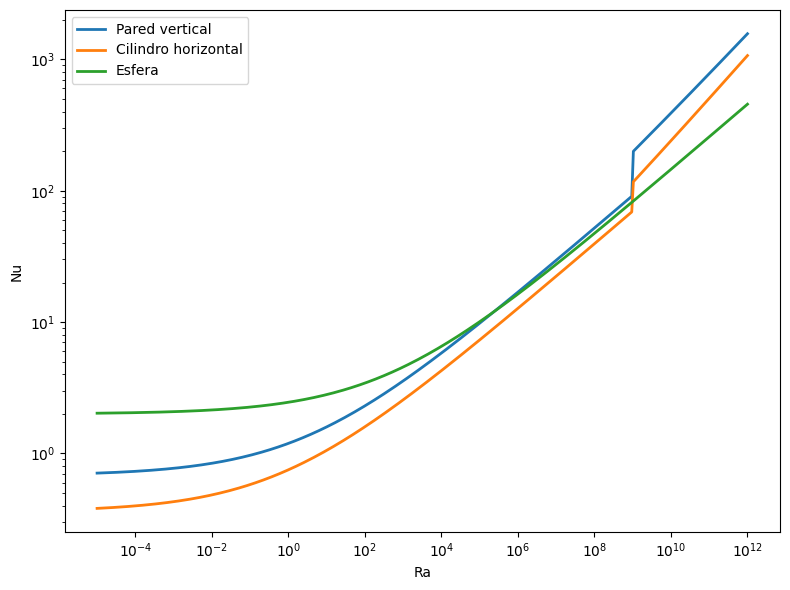

In [ ]:
# -----------------------------
# Librerías
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt
# -----------------------------
# Datos del problema
# -----------------------------
D = 0.20          # [m]
Ts = 500.0        # [K]
Tinf = 310.0      # [K]
Tf = (Ts + Tinf) / 2.0

# -----------------------------
# Propiedades del aire a Tf
# -----------------------------
k = 0.0331        # [W/mK]
nu = 25.5e-6      # [m^2/s]
mu = 22.52e-6     # [kg/m s]
cp = 1009.0       # [J/kg K]
beta = 1.0 / Tf   # [1/K]
g = 9.81          # [m/s^2]

# -----------------------------
# Números adimensionales
# -----------------------------
Pr = (mu * cp) / k

Ra_D = (g * beta * (Ts - Tinf) * D**3) / (nu**2) * Pr

# -----------------------------
# Correlación cilindro horizontal
# -----------------------------
term = (0.559 / Pr)**(9/16)
Nu_D = 0.36 + (0.518 * Ra_D**0.25) / ((1 + term)**(4/9))

# -----------------------------
# Coeficiente convectivo
# -----------------------------
h_c = (k / D) * Nu_D

# -----------------------------
# Pérdida de calor por unidad de longitud
# -----------------------------
A = np.pi * D
Qdot = h_c * A * (Ts - Tinf)

# -----------------------------
# Resultados
# -----------------------------
print("Resultados:")
print(f"Temperatura de película: Tf = {Tf:.1f} K")
print(f"Número de Prandtl: Pr = {Pr:.2e}")
print(f"Número de Rayleigh: Ra_D = {Ra_D:.2e}")
print(f"Número de Nusselt: Nu_D = {Nu_D:.2f}")
print(f"Coeficiente convectivo: h_c = {h_c:.2f} W/m^2 K")
print(f"Pérdida de calor por unidad de longitud: Qdot = {Qdot:.2f} W/m")



# -----------------------------
# Parámetros
# -----------------------------
Pr = 0.7                              # Prandtl típico del aire
Ra = np.logspace(-5, 12, 400)         # Vector Rayleigh

# -----------------------------
# FACTORES AUXILIARES
# -----------------------------

Psi_vert = (1 + (0.492/Pr)**(9/16))**(-16/9)
Psi_cil  = (1 + (0.559/Pr)**(9/16))**(-4/9)
Psi_esf  = (1 + (0.469/Pr)**(9/16))**(-4/9)

# -----------------------------
# PARED VERTICAL
# -----------------------------
Nu_vert = np.zeros_like(Ra)

for i in range(len(Ra)):
    if Ra[i] < 1e9:
        Nu_vert[i] = 0.68 + 0.670*(Ra[i]*Psi_vert)**0.25
    else:
        Nu_vert[i] = 0.68 + 0.67*(Ra[i]*Psi_vert)**0.25 * \
                     (1 + (1.6e-8*Ra[i]*Psi_vert)**(1/12))

# -----------------------------
# CILINDRO HORIZONTAL
# -----------------------------
Nu_cil = np.zeros_like(Ra)

for i in range(len(Ra)):
    if Ra[i] <= 1e9:
        Nu_cil[i] = 0.36 + (0.518*Ra[i]**0.25)/((1+(0.559/Pr)**(9/16))**(4/9))
    else:
        Nu_cil[i] = (0.60 + 0.387*(Ra[i]/((1+(0.559/Pr)**(9/16))**(16/9)))**(1/6))**2

# -----------------------------
# ESFERA
# -----------------------------
Nu_esf = 2 + (0.589*Ra**0.25)/((1+(0.469/Pr)**(9/16))**(4/9))

# -----------------------------
# GRÁFICA
# -----------------------------
plt.figure(figsize=(8,6))
plt.loglog(Ra, Nu_vert, label='Pared vertical', linewidth=2)
plt.loglog(Ra, Nu_cil, label='Cilindro horizontal', linewidth=2)
plt.loglog(Ra, Nu_esf, label='Esfera', linewidth=2)

plt.xlabel('Ra')
plt.ylabel('Nu')
plt.legend()
plt.tight_layout()
plt.show()

## Ejemplo 7.2.

In [ ]:
# ----------------------------------------------------------
# Librerías
# ----------------------------------------------------------
!pip install CoolProp
from CoolProp.CoolProp import PropsSI
import numpy as np

# ----------------------------------------------------------
# Datos del problema
# ----------------------------------------------------------
Ts = 109 + 273.15       # K, superficie de tubos
Ti = 17.5 + 273.15      # K, aire de entrada
V_max = 4.5           # m/s
ST = 2 * 2.54 / 100     # m (2 pulgadas)
D = 1 / 100             # m, diámetro externo
N = 56                  # número total de tubos
P = 101325              # Pa

# ----------------------------------------------------------
# Iteración
# ----------------------------------------------------------
T_out_old = 100+273.15          # valor inicial
tol = 1e-4
error = 1
it = 0
max_it = 500

while error > tol and it < max_it:

    # Temperatura promedio
    T_film = 0.5 * (Ti + T_out_old)

    # Propiedades del aire a T_film
    mu = PropsSI("V", "T", T_film, "P", P, "Air")
    rho = PropsSI("D", "T", T_film, "P", P, "Air")
    k = PropsSI("L", "T", T_film, "P", P, "Air")
    cp = PropsSI("CPMASS","T", T_film,"P",P,"Air")
    Pr = PropsSI("Prandtl","T",T_film,"P",P,"Air")

    # Propiedades a Ts para la corrección del prantl
    Pr_s = PropsSI("Prandtl", "T", Ts, "P", P, "Air")

    # Número de Reynolds
    Re = rho * V_max * D / mu

    # Correlación
    Nu = 0.033 * Re**0.8 * Pr**0.4 * (Pr / Pr_s)**0.25

    Nu_corr = 0.97 * Nu  # corrección
    h = Nu_corr * k / D

    # Área total externa
    A_total = N * np.pi * D * ST

    m_dot = rho * V_max * (8 * ST)

    # Nueva temperatura de salida
    T_out_new = Ts - (Ts - Ti) * np.exp(-(A_total * h) / (m_dot * cp))

    # Criterio de convergencia
    error = abs(T_out_new - T_out_old)
    T_out_old = T_out_new
    it += 1

# ----------------------------------------------------------
# Cálculo de la fuerza impulsora
# ----------------------------------------------------------
T_out = T_out_new

DT1 = Ts - Ti
DT2 = Ts - T_out
LMTD = (DT1 - DT2) / np.log(DT1 / DT2)

Q = h * A_total * LMTD   # W

# ----------------------------------------------------------
# Resultados
# ----------------------------------------------------------
print("Iteraciones:", it)
print("Temperatura de salida (°C):", T_out - 273.15)
print("Coeficiente h (W/m2K):", h)
print("ΔT logarítmica (K):", LMTD)
print("Razón de transferencia de calor (W/L):", Q)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 40.4 MB/s eta 0:00:00
Iteraciones: 3
Temperatura de salida (°C): 17.659849562317675
Coeficiente h (W/m2K): 43.72280738329117
ΔT logarítmica (K): 91.42005192719328
Razón de transferencia de calor (W/L): 357.23262533244656


## Ejemplo 7.3.

In [ ]:
# ----------------------------------------------------------
# Librerías
# ----------------------------------------------------------
import numpy as np
import pandas as pd

# ----------------------------------------------------------
# Datos del problema
# ----------------------------------------------------------
Di = 0.015   # [m]
Do_t = 0.020 # [m]
Dc = 0.033   # [m]

hi = 800     # [W/m^2K]
ho = 1000    # [W/m^2K]

Rf_i = 0.0002
Rf_o = 0.0003

k_acero = 16 # [W/mK]

L = 1


Ai = np.pi * Di
Ao = np.pi * Dc

# ----------------------------------------------------------
# Resistencias
# ----------------------------------------------------------
R_conv_i = 1 / (hi * Ai)
R_f_i = Rf_i / Ai
R_wall = np.log(Do_t / Di) / (2 * np.pi * k_acero)
R_f_o = Rf_o / Ao
R_conv_o = 1 / (ho * Ao)

Rtot = R_conv_i + R_f_i + R_wall + R_f_o + R_conv_o

# --------------------------
# COEFICIENTE GLOBAL
# --------------------------
C = 1 / Rtot
Ui = C / Ai
Uo = C / Ao


# ----------------------------------------------------------
# Resultados
# ----------------------------------------------------------
print("=== RESULTADOS PRINCIPALES ===")
print(f"Resistencia total R_tot = {Rtot:.6f} K/W")
print(f"U_i = {Ui:.2f} W/m2K")
print(f"U_o = {Uo:.2f} W/m2K")

# ----------------------------------------------------------
# Variación con material
# ----------------------------------------------------------

materiales = {
    "Cobre": 400,
    "Aluminio": 205,
    "Acero Inoxidable": 16,
    "Plástico": 0.2
}

filas = []

# ----------------------------------------------------------
# Ciclo
# ----------------------------------------------------------
for i, k in materiales.items():
    Rw = np.log(Do_t / Di) / (2 * np.pi * k)
    Rtot_m = R_conv_i + R_f_i + Rw + R_f_o + R_conv_o
    C_m = 1 / Rtot_m
    Ui_m = C_m / Ai
    Uo_m = C_m / Ao
    filas.append([i, k, Rw, Ui_m, Uo_m])

df = pd.DataFrame(filas, columns=["Material", "k (W/mK)", "R_pared (K/W)", "U_i (W/m2K)", "U_o (W/m2K)"])

print("=== TABLA DE VARIACIÓN CON MATERIAL ===")
print(df.to_string(index=False))


=== RESULTADOS PRINCIPALES ===
Resistencia total R_tot = 0.046171 K/W
U_i = 459.61 W/m2K
U_o = 208.91 W/m2K
=== TABLA DE VARIACIÓN CON MATERIAL ===
        Material  k (W/mK)  R_pared (K/W)  U_i (W/m2K)  U_o (W/m2K)
           Cobre     400.0       0.000114   488.686151   222.130069
        Aluminio     205.0       0.000223   487.463880   221.574491
Acero Inoxidable      16.0       0.002862   459.609503   208.913410
        Plástico       0.2       0.228930    77.948478    35.431127


## Ejemplo 7.4.

In [ ]:
# ----------------------------------------------------------
# Librerías
# ----------------------------------------------------------
!pip install CoolProp
from CoolProp.CoolProp import PropsSI
import numpy as np

# ----------------------------------------------------------
# Datos del problema
# ----------------------------------------------------------
m_f = 5 # [kg/s]
m_c = 6 # [kg/s]
t_e = 13 +273.15 # Temperatura entrada fluido frío [K]
t_s = 88 + 273.15 # Temperatura salida fluido frío [K]
T_e = 400 + 273.15 # Temperatura entrada fluido caliente [K]
D = 20e-2 # Diametro tubo interno [m]
U = 550 # Coeficiente global [W/m^2 K]

t_prom = (t_e + t_s)/2 # Temperatura promedio

# ----------------------------------------------------------
# Propiedades de los fluidos
# ----------------------------------------------------------

Cp_c =PropsSI("CPMASS","T",T_e,"P",101325,"water")
Cp_f = PropsSI("CPMASS","T",t_prom,"P",101325,"water")

# ----------------------------------------------------------
# Cálculos
# ----------------------------------------------------------
C_c = m_c * Cp_c  # Tasa del fluido caliente (Gas)
C_f = m_f * Cp_f  # Tasa del fluido frío (Líquido)

# Determinación de Cmin y Cmax para el método NTU
C_min = min(C_c, C_f)
C_max = max(C_c, C_f)

# Relación de capacidades
C= C_min / C_max
q_max = C_min *(T_e- t_e)
 # Balance dde energía
q= C_f *( t_s- t_e)
eficiencia = q/q_max
 # Uso de la relación
NTU = (1/(C-1))*np.log((eficiencia-1)/(eficiencia*C -1))

A = NTU*C_min/U
L= A/(np.pi*D)


 # ----------------------------------------------------------
# Resultados
# ----------------------------------------------------------
print("-" * 30)

print(f"Efectividad:       {eficiencia:.3f}")
print(f"NTU calculado:     {NTU:.3f}")
print("-" * 30)
print(f"LONGITUD NECESARIA: {L:.2f} metros")

------------------------------
Efectividad:       0.326
NTU calculado:     0.442
------------------------------
LONGITUD NECESARIA: 15.89 metros


## Ejemplo 7.5.

In [ ]:
# ============================================================
# DISEÑO DE INTERCAMBIADOR DE CALOR DOBLE TUBO
# ============================================================

# ----------------------------------------------------------
# Librerías
# ----------------------------------------------------------
import numpy as np

print(" Diseño INT. DOBLE TUBO")
print("\n=============================================")

# ----------------------------------------------------------
# Datos de entrada
# ----------------------------------------------------------

# Caudal másico del fluido A [kg/s]
m_A = 1.300

# Calores específicos a temperatura promedio [J/kg K]
cp_A = 1780
cp_B = 1800

# Temperaturas de entrada y salida [K]
TA_in = 298
Tb_out = 315

TB_in = 348
Tt_out = 306

# Densidades [kg/m^3]
rho_A = 880
rho_B = 855

# Viscosidades dinámicas [Pa s]
mu_A = 5.00e-4
mu_B = 4.09e-4

# Conductividades térmicas [W/m K]
k_A = 0.1575
k_B = 0.1471

# Diámetros característicos [m]
D_i = 0.035     # Diámetro interno del tubo
D_1 = 0.042     # Diámetro externo del tubo interno
D_2 = 0.053     # Diámetro interno del tubo externo

# Longitud de cada horquilla [m]
Lh = 6

# Aceleración de la gravedad [m/s^2]
g = 9.81

# Factor de ensuciamiento global [m^2·K/W]
Rd = 0.000352

# Factores j_H para transferencia de calor (correlaciones empíricas)
jH_i = 236
jH_o = 167

# Área superficial externa de la tubería por metro de longitud [m^2/m]
Aft = 0.1327

# ============================================================
# ---------------- (1) BALANCE DE ENERGÍA --------------------
# ============================================================

# Calor transferido desde el fluido A [W]
Q = m_A * cp_A * (Tb_out - TA_in)

# Caudal másico requerido del fluido B [kg/s]
m_t = Q / (cp_B * (TB_in - Tt_out))

# ============================================================
# ---------------- (2) LMTD ---------------------------------
# ============================================================

# Diferencias de temperatura en los extremos
DT1 = TB_in - Tb_out
DT2 = Tt_out - TA_in

# Diferencia media logarítmica de temperatura
LMTD = (DT1 - DT2) / np.log(DT1 / DT2)

# ============================================================
# ---------------- (3) ÁREAS DE FLUJO ------------------------
# ============================================================

# Área interna del tubo
Ai = np.pi * D_i**2 / 4

# Área de flujo en el anulo
Aan = np.pi * (D_2**2 - D_1**2) / 4

# Diámetro equivalente hidráulico del anulo
D_e = (D_2**2 - D_1**2) / D_1

# ============================================================
# ---------------- (4) VELOCIDADES MÁSICAS -------------------
# ============================================================

# Flujo másico por unidad de área
G_i = m_A / Ai
G_o = m_t / Aan

# ============================================================
# ---------------- (5) NÚMERO DE REYNOLDS --------------------
# ============================================================

Re_i = G_i * D_i / mu_A
Re_o = G_o * D_e / mu_B

# ============================================================
# ---------------- (6) NÚMERO DE PRANDTL ---------------------
# ============================================================

Pr_i = cp_A * mu_A / k_A
Pr_o = cp_B * mu_B / k_B

# ============================================================
# ---------------- (9) COEFICIENTES h ------------------------
# ============================================================

# Coeficientes convectivos individuales
hi = (jH_i * k_A / D_i) * Pr_i**(1/3)
ho = (jH_o * k_B / D_e) * Pr_o**(1/3)

# Corrección del coeficiente interno al área externa
hio = hi * (D_i**2) / (D_1**2)

# ============================================================
# ---------------- (10) COEFICIENTES U -----------------------
# ============================================================

# Coeficiente global limpio
Uc = (hio * ho) / (hio + ho)

# Coeficiente global con ensuciamiento
Ud = 1 / (1 / Uc + Rd)

# ============================================================
# ---------------- (11) ÁREA REQUERIDA -----------------------
# ============================================================

# Área necesaria para cumplir la carga térmica
A = Q / (Ud * LMTD)

# Longitud total requerida
Lreq = A / Aft

# Número de horquillas
N_H = Lreq / (2 * Lh)

# ============================================================
# ================= CAÍDAS DE PRESIÓN ========================
# ============================================================

# ---------------- TUBO ----------------

ReD_i = Re_i
f_i = 0.0035 + 0.264 / ReD_i**0.42

DP_tube = 4 * f_i * (Lreq / D_i) * (G_i**2 / (2 * rho_A))

# ---------------- ANULO ----------------

D_eo = D_2 - D_1
ReD_o = (D_eo * G_o) / mu_B
f_o = 0.0035 + 0.264 / ReD_o**0.42

DPf_o = 4 * f_o * (Lreq / D_eo) * (G_o**2 / (2 * rho_B**2))
V = G_o / rho_B
DPa_o = 3 * (V**2 / 2)

DP_ann = (DPf_o + DPa_o) * rho_B

# ============================================================
# ---------------- SALIDA DE RESULTADOS ----------------------
# ============================================================

print("--- BALANCE ---")
print(f"Q                     = {Q:.1f} W")
print(f"W_t                   = {m_t:.3f} kg/s\n")

print("--- LMTD ---")
print(f"LMTD                  = {LMTD:.3f} K\n")

print("--- ÁREAS DE FLUJO ---")
print(f"Ai                    = {Ai:.6f} m^2")
print(f"Aan                   = {Aan:.6f} m^2")
print(f"D_e                   = {D_e:.4f} m\n")

print("--- HIDRAULICA ---")
print(f"G_i                   = {G_i:.3f} kg/(s·m^2)")
print(f"G_o                   = {G_o:.3f} kg/(s·m^2)")
print(f"Re_i                  = {Re_i:.0f}")
print(f"Re_o                  = {Re_o:.0f}\n")

print("--- TRANSFERENCIA ---")
print(f"Pr_i                  = {Pr_i:.4f}")
print(f"Pr_o                  = {Pr_o:.4f}")
print(f"h_i                   = {hi:.3f} W/(m^2·K)")
print(f"h_o                   = {ho:.3f} W/(m^2·K)")
print(f"h_io                  = {hio:.3f} W/(m^2·K)")
print(f"Uc                    = {Uc:.3f} W/(m^2·K)")
print(f"Ud                    = {Ud:.3f} W/(m^2·K)\n")

print("--- AREA ---")
print(f"Area requerida        = {A:.2f} m^2")
print(f"Longitud requerida    = {Lreq:.0f} m")
print(f"Horquillas            = {N_H:.0f}\n")

print("--- CAIDAS DE PRESION ---")
print(f"Factor de fricción i  = {f_i:.6f}")
print(f"Factor de fricción o  = {f_o:.6f}")
print(f"DeltaP tubo           = {DP_tube:.3f} Pa")
print(f"DeltaP anulo          = {DP_ann:.3f} Pa")

# Las caídas de presión no deben superar 68947.6 Pa
print("\n=============================================")


 Diseño INT. DOBLE TUBO

--- BALANCE ---
Q                     = 39338.0 W
W_t                   = 0.520 kg/s

--- LMTD ---
LMTD                  = 17.642 K

--- ÁREAS DE FLUJO ---
Ai                    = 0.000962 m^2
Aan                   = 0.000821 m^2
D_e                   = 0.0249 m

--- HIDRAULICA ---
G_i                   = 1351.193 kg/(s·m^2)
G_o                   = 633.993 kg/(s·m^2)
Re_i                  = 94584
Re_o                  = 38568

--- TRANSFERENCIA ---
Pr_i                  = 5.6508
Pr_o                  = 5.0048
h_i                   = 1891.593 W/(m^2·K)
h_o                   = 1688.845 W/(m^2·K)
h_io                  = 1313.606 W/(m^2·K)
Uc                    = 738.889 W/(m^2·K)
Ud                    = 586.378 W/(m^2·K)

--- AREA ---
Area requerida        = 3.80 m^2
Longitud requerida    = 29 m
Horquillas            = 2

--- CAIDAS DE PRESION ---
Factor de fricción i  = 0.005647
Factor de fricción o  = 0.007908
DeltaP tubo           = 19183.089 Pa
DeltaP anulo   

## Ejemplo 7.6.

In [ ]:
# ----------------------------------------------------------
# Librerías
# ----------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 1. DATOS EXPERIMENTALES (Tomados de la lectura de la Fig. 28 de Kern)
Re_data = np.array([2000, 4000, 10000, 20000, 50000, 100000, 500000, 1000000])

# Valores leídos  de jH (factor de transferencia de calor)

jH_data = np.array([23, 34.5, 57.0, 84, 139.0, 202.0, 490.0, 710.0])

# ----------------------------------------------------------
# Función del modelo
# ----------------------------------------------------------

def modelo_potencia(x, a, b):
    return a * (x ** b)

# ----------------------------------------------------------
# Regresión
# ----------------------------------------------------------
parametros_optimos, covarianza = curve_fit(modelo_potencia, Re_data, jH_data)

a_calculado = parametros_optimos[0]
b_calculado = parametros_optimos[1]

# ----------------------------------------------------------
# R^2
# ----------------------------------------------------------
residuos = jH_data - modelo_potencia(Re_data, *parametros_optimos)
suma_cuadrados_residuos = np.sum(residuos**2)
suma_cuadrados_total = np.sum((jH_data - np.mean(jH_data))**2)
r_cuadrado = 1 - (suma_cuadrados_residuos / suma_cuadrados_total)

# ----------------------------------------------------------
# Resultados
# ----------------------------------------------------------
print("-" * 30)
print("RESULTADOS DE LA REGRESIÓN")
print("-" * 30)
print(f"Ecuación obtenida: jH = {a_calculado:.4f} * Re^{b_calculado:.4f}")
print(f"Coeficiente a : {a_calculado:.4f}")
print(f"Exponente b : {b_calculado:.4f}")
print(f"Calidad del ajuste (R^2): {r_cuadrado:.4f}")

------------------------------
RESULTADOS DE LA REGRESIÓN
------------------------------
Ecuación obtenida: jH = 0.3808 * Re^0.5452
Coeficiente a : 0.3808
Exponente b : 0.5452
Calidad del ajuste (R^2): 1.0000


## Ejemplo 7.7.

In [ ]:
# Base de datos


# ==========================================
# 0. Bases de datos (Kern)
# ==========================================

Tabla_10 = {
    "0.75": {
        "BWG":    [10, 11, 12, 13, 14, 15, 16, 17,18],
        "Wall_thickness_in": [0.134, 0.120, 0.109, 0.095, 0.083, 0.072, 0.065, 0.058, 0.049],
        "ID_in":  [0.482, 0.510, 0.532, 0.560, 0.584, 0.606, 0.620, 0.634, 0.652],
        "Flow_area_in2": [0.182, 0.204, 0.223, 0.247, 0.268, 0.289, 0.302, 0.314, 0.334],
        "Surface_out_ft2/ft": [0.1963] * 9,
        "Surface_in_ft2/ft": [0.1263,0.1335, 0.1393,0.1466, 0.1529, 0.1587, 0.1623,0.1660,0.1707],
        "Weight_lb/ft": [0.965, 0.884, 0.817, 0.727, 0.647, 0.571, 0.520, 0.469, 0.401]
    },

    "1": {
        "BWG":    [8, 9, 10, 11, 12, 13, 14, 15, 16, 17,18],
        "Wall_thickness_in": [0.165, 0.148, 0.134, 0.120, 0.109, 0.095, 0.083, 0.072, 0.065, 0.058, 0.049],
        "ID_in":  [0.670, 0.704, 0.732, 0.760, 0.782, 0.810, 0.834, 0.856, 0.870, 0.884, 0.902],
        "Flow_area_in2": [0.355, 0.389, 0.421, 0.455, 0.479, 0.515, 0.546, 0.576, 0.594, 0.613, 0.639],
        "Surface_out_ft2/ft": [0.2618] * 11,
        "Surface_in_ft2/ft": [0.1754,0.1843,0.1916,0.1990,0.2048,0.2121,0.2183,0.2241,0.2277, 0.2314,0.2361],
        "Weight_lb/ft": [1.61, 1.47, 1.36, 1.23, 1.14, 1.00, 0.890, 0.781, 0.710, 0.639, 0.545]

    },

    "1.25": {
        "BWG":    [8, 9, 10, 11, 12, 13, 14, 15, 16, 17,18],
        "Wall_thickness_in": [0.165, 0.148, 0.134, 0.120, 0.109, 0.095, 0.083, 0.072, 0.065, 0.058,0.049],
        "ID_in":  [0.920,0.954,0.982,1.01,1.03,1.06,1.08,1.11,1.12,1.13,1.15],
        "Flow_area_in2": [0.665, 0.714, 0.757, 0.800, 0.836, 0.884, 0.923, 0.960, 0.985, 1.01, 1.04],
        "Surface_out_ft2/ft": [0.3271] * 11,
        "Surface_in_ft2/ft": [0.2409,0.2498,0.2572,0.2644,0.2701,0.2775,0.2839,0.2896,0.2932,0.2969,0.3015],
        "Weight_lb/ft": [2.09, 1.91, 1.75, 1.58, 1.45, 1.28, 1.13, 0.991, 0.900,0.808,0.688]
    },

    "1.5": {
        "BWG":    [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
        "Wall_thickness_in": [0.165, 0.148, 0.134, 0.120, 0.109, 0.095, 0.083, 0.072, 0.065, 0.058, 0.049],
        "ID_in":  [1.17, 1.20, 1.23, 1.26, 1.28, 1.31, 1.33, 1.36, 1.37, 1.38, 1.40],
        "Flow_area_in2": [1.075, 1.14, 1.19, 1.25, 1.29, 1.35, 1.40, 1.44, 1.47, 1.50, 1.54],
        "Surface_out_ft2/ft": [0.3925] * 11,
        "Surface_in_ft2/ft": [0.3063,0.3152,0.3225,0.3299,0.3356,0.3430,0.3492,0.3555,0.3587,0.3623,0.3670],
        "Weight_lb/ft": [2.57, 2.34, 2.14, 1.98, 1.77, 1.56, 1.37, 1.20, 1.09, 0.978, 0.831]
    }
}


tube_layout = {
    "3/4 in OD, 1 in pitch": {
        'OD_in' : 0.75,
        'pitch_in':1.0,
        'data':{
        8:  {"1-P": 32, "2-P": 26, "4-P": 20, "6-P": 20, "8-P": None},
        10: {"1-P": 52, "2-P": 52, "4-P": 40, "6-P": 36, "8-P": None},
        12: {"1-P": 81, "2-P": 76, "4-P": 68, "6-P": 68, "8-P": 60},
        13.5: {"1-P": 97, "2-P": 90, "4-P": 82, "6-P": 76, "8-P": 70},
        15.5: {"1-P": 137, "2-P": 124, "4-P": 116, "6-P": 108, "8-P": 108},
        17.5: {"1-P": 177, "2-P": 166, "4-P": 158, "6-P": 150, "8-P": 142},
        19.5: {"1-P": 224, "2-P": 220, "4-P": 204, "6-P": 192, "8-P": 188},
        21.25: {"1-P": 277, "2-P": 270, "4-P": 246, "6-P": 240, "8-P": 234},
        23.25: {"1-P": 341, "2-P": 324, "4-P": 308, "6-P": 302, "8-P": 292},
        25: {"1-P": 413, "2-P": 394, "4-P": 370, "6-P": 356, "8-P": 346},
        27: {"1-P": 481, "2-P": 460, "4-P": 432, "6-P": 420, "8-P": 408},
        29: {"1-P": 553, "2-P": 526, "4-P": 480, "6-P": 468, "8-P": 456},
        31: {"1-P": 657, "2-P": 640, "4-P": 600, "6-P": 580, "8-P": 560},
        33: {"1-P": 749, "2-P": 718, "4-P": 688, "6-P": 676, "8-P": 648},
        35: {"1-P": 845, "2-P": 824, "4-P": 780, "6-P": 766, "8-P": 748},
        37: {"1-P": 934, "2-P": 914, "4-P": 886, "6-P": 866, "8-P": 838},
        39: {"1-P": 1049, "2-P": 1024, "4-P": 982, "6-P": 968, "8-P": 948},
        }
    },
    "1 in OD, 1.25 in pitch": {
        'OD_in' : 1,
        'pitch_in':1.25,
        'data':{
        8:  {"1-P": 21, "2-P": 16, "4-P": 14, "6-P": None, "8-P": None},
        10: {"1-P": 32, "2-P": 26, "4-P": 24, "6-P": 24, "8-P": None},
        12: {"1-P": 48, "2-P": 45, "4-P": 40, "6-P": 38, "8-P": 36},
        13.5: {"1-P": 61, "2-P": 56, "4-P": 52, "6-P": 48, "8-P": 44},
        15.5: {"1-P": 81, "2-P": 76, "4-P": 68, "6-P": 68, "8-P": 64},
        17.5: {"1-P": 112, "2-P": 112, "4-P": 96, "6-P": 90, "8-P": 82},
        19.5: {"1-P": 138, "2-P": 132, "4-P": 128, "6-P": 122, "8-P": 116},
        21.25: {"1-P": 177, "2-P": 166, "4-P": 158, "6-P": 152, "8-P": 148},
        23.25: {"1-P": 213, "2-P": 208, "4-P": 192, "6-P": 184, "8-P": 184},
        25: {"1-P": 260, "2-P": 252, "4-P": 238, "6-P": 226, "8-P": 222},
        27: {"1-P": 300, "2-P": 288, "4-P": 278, "6-P": 268, "8-P": 260},
        29: {"1-P": 341, "2-P": 326, "4-P": 300, "6-P": 294, "8-P": 286},
        31: {"1-P": 406, "2-P": 398, "4-P": 380, "6-P": 368, "8-P": 358},
        33: {"1-P": 465, "2-P": 460, "4-P": 432, "6-P": 420, "8-P": 414},
        35: {"1-P": 522, "2-P": 518, "4-P": 488, "6-P": 484, "8-P": 472},
        37: {"1-P": 596, "2-P": 574, "4-P": 562, "6-P": 544, "8-P": 532},
        39: {"1-P": 665, "2-P": 644, "4-P": 624, "6-P": 612, "8-P": 600},
        }
    },
        "1.25 in OD, 1.625 in pitch": {
        'OD_in' : 1.25,
        'pitch_in':1.625,
        "data":{
        10:  {"1-P": 16, "2-P": 12, "4-P": 10, "6-P": None, "8-P": None},
        12:  {"1-P": 30, "2-P": 24, "4-P": 22, "6-P": 16, "8-P": 16},
        13.5: {"1-P": 32, "2-P": 30, "4-P": 30, "6-P": 22, "8-P": 22},
        15.5: {"1-P": 44, "2-P": 40, "4-P": 37, "6-P": 35, "8-P": 31},
        17.5: {"1-P": 56, "2-P": 53, "4-P": 51, "6-P": 48, "8-P": 44},
        19.5: {"1-P": 78, "2-P": 73, "4-P": 71, "6-P": 64, "8-P": 56},
        21.25: {"1-P": 96, "2-P": 90, "4-P": 86, "6-P": 82, "8-P": 78},
        23.25: {"1-P": 127, "2-P": 112, "4-P": 106, "6-P": 102, "8-P": 96},
        25: {"1-P": 140, "2-P": 135, "4-P": 127, "6-P": 123, "8-P": 115},
        27: {"1-P": 166, "2-P": 160, "4-P": 151, "6-P": 146, "8-P": 140},
        29: {"1-P": 193, "2-P": 188, "4-P": 178, "6-P": 174, "8-P": 166},
        31: {"1-P": 226, "2-P": 220, "4-P": 209, "6-P": 202, "8-P": 193},
        33: {"1-P": 258, "2-P": 252, "4-P": 244, "6-P": 238, "8-P": 226},
        35: {"1-P": 293, "2-P": 287, "4-P": 275, "6-P": 268, "8-P": 258},
        37: {"1-P": 334, "2-P": 322, "4-P": 311, "6-P": 304, "8-P": 293},
        39: {"1-P": 370, "2-P": 362, "4-P": 348, "6-P": 342, "8-P": 336},
        }
    },
    "1.5 in OD, 1.875 in pitch": {
        'OD_in' : 1.5,
        'pitch_in':1.875,
        'data':{
        12:  {"1-P": 16, "2-P": 16, "4-P": 12, "6-P": 12, "8-P": None},
        13.5: {"1-P": 22, "2-P": 22, "4-P": 16, "6-P": 16, "8-P": None},
        15.5: {"1-P": 29, "2-P": 29, "4-P": 25, "6-P": 24, "8-P": 22},
        17.5: {"1-P": 39, "2-P": 39, "4-P": 34, "6-P": 32, "8-P": 29},
        19.5: {"1-P": 50, "2-P": 48, "4-P": 45, "6-P": 43, "8-P": 39},
        21.25: {"1-P": 62, "2-P": 60, "4-P": 57, "6-P": 54, "8-P": 50},
        23.25: {"1-P": 78, "2-P": 74, "4-P": 70, "6-P": 66, "8-P": 62},
        25: {"1-P": 94, "2-P": 90, "4-P": 86, "6-P": 84, "8-P": 78},
        27: {"1-P": 112, "2-P": 108, "4-P": 102, "6-P": 98, "8-P": 94},
        29: {"1-P": 131, "2-P": 127, "4-P": 120, "6-P": 116, "8-P": 112},
        31: {"1-P": 151, "2-P": 146, "4-P": 141, "6-P": 138, "8-P": 131},
        33: {"1-P": 176, "2-P": 170, "4-P": 164, "6-P": 160, "8-P": 151},
        35: {"1-P": 202, "2-P": 196, "4-P": 188, "6-P": 182, "8-P": 176},
        37: {"1-P": 224, "2-P": 220, "4-P": 217, "6-P": 210, "8-P": 202},
        39: {"1-P": 252, "2-P": 246, "4-P": 237, "6-P": 230, "8-P": 224},
        }
    }
}



In [ ]:
# ============================================================
# DISEÑO DE INTERCAMBIADOR DE CORAZA Y TUBBOS
# ============================================================
# Ejecutar antes la base de datos
import numpy as np
import pandas as pd
# Primero instala si no la tienes: pip install tabulate
from tabulate import tabulate

Diametros =  ["0.75","1", "1.25", "1.5" ] # Pulgadas
L_disponibles= np.array([6,8,12,14]) # ft

Arr = ["3/4 in OD, 1 in pitch","1 in OD, 1.25 in pitch","1.25 in OD, 1.625 in pitch", "1.5 in OD, 1.875 in pitch"]

# ----------------------------------------------------------
# Parámetros
# ----------------------------------------------------------

# Temperaturas de operación, 1 es entrada, 2 salida, mayúscula para fluido caliente y minúscula para frío

T1 = 90 # [°C]
T2 = 50 # [°C]
t1  = 30 # [° C]
t2 = 40 # [°C]

# Factores de obstrucción
Rd_ac =  0.00035  # [m^2 K/ w]
Rd_agua = 0.00018 # [m^2 K/ w]

# Caida de presión permitida
Pressure_drop_ac =100e3 # [Kpa]
Pressure_drop_agua = 100e3 # [Kpa]

# Límites de velocidad para cada fluido
V_límite_ac = np.array ([1.0,3.0]) # [m / s]
V_límite_agua = np.array ([0.5,2.0]) # [m / s]

# flujos másicos

M_ac = 12 # [kg/s]

# ----------------------------------------------------------
# Funciones
# ----------------------------------------------------------
def LMDT_cont(T1,T2,t1,t2):
  D1= T1-t2
  D2= T2-t1
  return (D2-D1)/(np.log(D2/D1))

# Factor de corrección para 1 paso por coraza y 2 por tubos

def Ft12(T1,T2,t1,t2):
  R = (T1-T2)/(t2-t1)
  S = (t2-t1)/(T1-t1)
  #Términos dentro de la raiz
  raiz1 = np.sqrt(R**2 + 1)
  # Numerador
  Numerador = raiz1*np.log((1-S)/(1-R*S))
  # Denominador
  parte_superior = 2 - S*(R+1-raiz1)
  parte_inferior = 2- S*(R + 1 + raiz1)
  Denominador = (R-1)*np.log((parte_superior/parte_inferior))
  return Numerador/Denominador

# Factor de corrección para 2 pasos por los tubos  y 4 por la coraza

def Ft24(T1,T2,t1,t2):
  R = (T1-T2)/(t2-t1)
  S = (t2-t1)/(T1-t1)
  # Términos dentro de la raíz
  raiz1 = np.sqrt((1 - S) * (1 - R * S))
  raiz2 = np.sqrt(R**2  + 1)
  # Numerador de la ecuación
  numerador = (raiz2/(2*(R-1)) ) *np.log((1-S)/(1-R*S))
  # Denominador de la ecuación
  parte_superior = 2 / S - 1 - R + (2 / S) * raiz1 + raiz2
  parte_inferior = 2 / S - 1 - R + (2 / S) * raiz1 - raiz2
  denominador = np.log(parte_superior / parte_inferior)
  # Cálculo final
  Ft = numerador / denominador
  return Ft



# ----------------------------------------------------------
# Propiedades fisicoquímicas
# ----------------------------------------------------------
T_prom = (T1+T2)/2
t_prom = (t1+t2)/2

# Aceite
rho_ac = 786.4 # [kg/m^3]
cp_ac= 2177 # [J/ Kg K]
mu_ac = 1.89e-3 # [Pa s]
k_ac = 0.122 # [W/ m K]
# Agua
rho_agua = 995 # [kg/m^3]
cp_agua= 4187  # [J/ Kg K]
mu_agua = 0.72e-3 # [Pa s]
k_agua = 0.59 # [W/ m K]
#Tuberías
k_tubo = 40 # [W/m°C]
paso = "2-P"

# ==========================================
# 1. Balance de energía
# ==========================================

# Balance de calor para el aceite
Q = M_ac*cp_ac*(T1-T2)
print(f'El calor es {Q} W')

# Balance de calor para el agua
M_agua = Q/(cp_agua*(t2-t1))
print(f'El flujo de agua es {M_agua} kg/s')


# ==========================================
# 2. Determinación de DMLT
# ==========================================


LMDT = LMDT_cont(T1,T2,t1,t2)
print(f'El LMDT es {LMDT} °C')
Ft = Ft24(T1,T2,t1,t2)
print(f'El factor de corrección es {Ft}')
fuerza_imp = LMDT*Ft
print(f'La fuerza impulsora real es  {fuerza_imp} ° C')




# ==========================================
# 3. Suponer U_D
# ==========================================

# En este caso se acota para la  función.

def evaluar_convergente(Ud_inicial=300,
                        U_d_min=200,
                        U_d_max=450):

  resultados= []
  # ============================================
  # 4. Calcular el area de transferencia de calor
  # ============================================
  As_requ_init =  Q/(fuerza_imp * Ud_inicial)

  # ============================================
  # 5. Definición de la configuraión geométrica
  # ============================================

  for i in Diametros: # Recorremos los diametros de los tubos.
    DE = float(i) *0.0254 # diámetro externo de los tubos [m]
    arreglo = Arr[Diametros.index(i)] # arreglo correspondiente
    pitch_in = tube_layout[str(arreglo)]['pitch_in'] # pitch [in]
    pitch_m = pitch_in * 0.0254 # pitch [m]
    tubo_cfg = tube_layout

    for L_ft in L_disponibles: # Recorremos las longitudes disponibles
      L_m=L_ft*0.3048 # Longitudes comunes [m]
      L_in = L_ft *12 #Longitud [in]

      As_req = Q / (fuerza_imp * Ud_inicial)
      N_p = As_req / (np.pi * DE * L_m) # Numero de tubos calculados
      candidatos_validos = []
      for BWG in Tabla_10[str(i)]['BWG']: # Recorremos los espesores
        idex= Tabla_10[str(i)]['BWG'].index(BWG)
        # Barremos en orden

        carcasas_disponibles = sorted(list(tube_layout[str(arreglo)]['data'].keys())) # Entrada a la base de datss
        for shell_id in carcasas_disponibles: # Recorremos el tamaño de coraza
          for paso in ["1-P", "2-P", "4-P", "6-P", "8-P"]:
            Nt_real = tube_layout[str(arreglo)]['data'][shell_id][paso]

            if Nt_real is None:
                continue
            if Nt_real < N_p:  # Verificando que valores hay o no en la tabla
                continue

            candidatos_validos.append({
                'shell_id': shell_id,
                'BWG': BWG,
                'pasos': paso,
                'Nt': Nt_real,
                'L_tubo': L_m
            })

            # ====================================================
            # 6. Cálculo del coeficiente convectivo por la  coraza
            # ====================================================

            Claro = pitch_m -DE # Claro [m]
            B = 0.3*shell_id*0.0254 # [m]
            a_s = (shell_id*0.0254  * Claro * B) / (pitch_m ) # Area de la coraza [m^2]
            G_s = M_agua / a_s # masa- velocidad de la coraza [m/(sm^2)]
            D_eq_s = (
                4 * (pitch_m**2 - np.pi * (DE)**2 / 4)
                / (np.pi * (DE)))     # para un arreglo cuadrado  [m]
            Re_s = D_eq_s * G_s / mu_agua
            h_o = 0.3808 *Re_s**(0.5452)*(k_agua/D_eq_s)*(cp_ac*mu_agua/k_agua)**(1/3)

            # ====================================================
            # 7. Cálculo del coeficiente convectivo por los tubos
            # ====================================================

            n_pasos = int(paso[0])
            A_flow_in2 = Tabla_10[str(i)]["Flow_area_in2"][idex] # Area de flujo desde las tablas [in^2]
            a_t = Nt_real * A_flow_in2 / (144 * n_pasos) # Area de los tubos [ft^2]
            a_t_m = a_t * 0.3048**2 # Area de los tubos [m^2]
            G_t = M_ac / a_t_m # masa velocidad por los tubos  [m/(sm^2)]
            DI = Tabla_10[i]["ID_in"][idex] * 0.0254 # diametro interno de los tubos [m]
            Re_p = DI * G_t / mu_ac  # Número de Reynolds
            Pr_ac = cp_ac* mu_ac / k_ac # Número de Prantl

            h_i = 0.023 * Re_p**0.8 * Pr_ac**0.33 * (k_ac / DI)

            # ====================================================
            # 8. Cálculo del coeficiente global limpio y de diseño
            # ====================================================


            h_io = h_i * (DI / DE)
            U_c = (1/h_io + 1/ h_o +  (DE* np.log(DE/DI)/(2 * k_tubo )) )**-1
            Ud_conv = 1 / (1/U_c + Rd_ac*(DI / DE) + Rd_agua)

            # =======================
            # 9. Verificación térmica
            # =======================
            if not (U_d_min <= Ud_conv <= U_d_max):
              continue

            # cálculo de las velocidades por cada lado
            V_s = G_s/ (rho_agua)
            V_t = G_t  / ( rho_ac)


            # ====================================================
            # 10. Cálculo de la caída de presión por la coraza
            # ====================================================

            f_s = 2.5074*Re_s**(-0.2352)
            Nm1 = int( L_m / (B ) ) # Numero de cruces por los bafles


            dP_s = (f_s * (G_s**2) * shell_id* 0.0254* Nm1) / (2 * rho_agua * D_eq_s)  # Pa


             # ====================================================
            # 11. Cálculo de la caída de presión por los tubos
            # ====================================================
            rug_t = 4.5e-5
            f_t = (-1.8 * np.log10((6.9/Re_p) + ((rug_t/DI)/3.7)**1.11))**-2 # ecuación de Haland

            dP_tr = (f_t/(2) * G_t**2 * L_m * n_pasos
                                        / (DI *rho_ac)) # [Pa]

            dP_tl = 2*n_pasos*G_t**2 / ( rho_ac) # [Pa]
            dP_t = dP_tr + dP_tl

             # ====================================================
            # 12. Verificaciones
            # ====================================================

            #  FILTRO HIDRÁULICO (Caída de Presión)

            if dP_s > Pressure_drop_agua and dP_t > Pressure_drop_ac:
              continue


            # FILTRO TÉRMICO (Capacidad de Transferencia)

            # Area real instalada en el equipo [m2]

            As_instalada = Nt_real * L_m * np.pi * DE

            # Calor que este equipo es capaz de transferir
            Q_capacidad = Ud_conv * As_instalada * fuerza_imp

            # Si la capacidad es menor al calor requerido (Q del  balance de energía ), el equipo es muy chico.
            if Q_capacidad < Q:
              continue

            # Verificación de las velocidades en los limites dados.

            if not (V_límite_ac[0] <= V_t <= V_límite_ac[1]):
              continue

            if not (V_límite_agua[0] <= V_s <= V_límite_agua[1]):
              continue



            # Calculamos el % de Sobrediseño
            porcentaje_overdesign = ((Q_capacidad - Q) / Q) * 100

            # Guardamos el candidato exitoso
            resultados.append({
                'shell_id': shell_id,   # Diámetro carcasa
                'L_ft': L_ft,           # Longitud
                'BWG': BWG,             # Espesor
                'pasos': paso,          # N pasos
                'Nt': Nt_real,          # N tubos
                'Ud': Ud_conv,          # U sucio calculado
                'Overdesign_%': porcentaje_overdesign,
                'Area_m2': As_instalada,
                'dP_shell_Pa': dP_s,
                'dP_tube_Pa': dP_t,
                'V_shell_m_s': V_s,
                'V_tube_m_s': V_t,


            })



  df = pd.DataFrame(resultados).sort_values("Area_m2").head(15)
  df_redondeado = df.round(2)
  print(" Top 15 diseños: \n", df_redondeado.to_string(index=False))



  return df

df_mejores = evaluar_convergente()

print()

El calor es 1044960 W
El flujo de agua es 24.957248626701695 kg/s
El LMDT es 32.740700038118746 °C
El factor de corrección es 0.9840836797618967
La fuerza impulsora real es  32.219588571492366 ° C
 Top 15 diseños: 
  shell_id  L_ft  BWG pasos  Nt     Ud  Overdesign_%  Area_m2  dP_shell_Pa  dP_tube_Pa  V_shell_m_s  V_tube_m_s
       27    14   10   4-P 432 355.41         20.90   110.32     33640.07    40388.61         0.71        1.20
       27    14   11   4-P 432 344.00         17.02   110.32     33640.07    30956.30         0.71        1.07
       29    14   14   8-P 456 444.83         59.72   116.45     26673.27   106597.02         0.62        1.55
       29    14   15   8-P 456 436.11         56.59   116.45     26673.27    89505.31         0.62        1.44
       29    14   17   8-P 456 427.47         53.49   116.45     26673.27    73595.59         0.62        1.32
       29    14   18   8-P 456 419.90         50.77   116.45     26673.27    63974.75         0.62        1.24
       